# Classification of B-ALL vs Healthy blood cells - Stacking with K-fold Cross Validation.

The top 3 CNN models with the highest average of weighted F1-scores across 3 folds are stacked together and fed to a second-level classifier which is SVM to generate the final prediction. 

## Steps include:

1. Importing dataset from Kaggle
2. Reading the train and test sets
3. Converting the data into tensors
4. Pre-processing pipeline
5. Data Augmentation
6. Model definition
7. Defining callbacks - Learning Rate scheduler, Early Stopping
8. Class weights for cost-sensitive learning
9. Base classifier Models' training using Stratified 5-fold cross-validation
10. Training the Meta-classifier (SVM)
11. Re-training the base classifier's on the entire train set
12. Evaluation of the stacked model on the test set

In [1]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-eac28f50-90a2-87e0-205c-e8113fad6030)


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import math, os, re, warnings, random
from sklearn.utils import class_weight
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
import os.path
from sklearn.datasets import make_blobs
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from numpy import dstack,hstack

In [4]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

## Import Dataset from Kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parveezrahman","key":"b45e47e3fbd44fa0e7efcf6d7e45e64d"}'}

In [ ]:
  ! mkdir ~/.kaggle #create a kaggle directory
  ! cp kaggle.json ~/.kaggle/   #copy the kaggle.json file to folder created
  ! chmod 600 ~/.kaggle/kaggle.json  #permission for the json to act
  !kaggle datasets download -d andrewmvd/leukemia-classification #Load the Leukemia Classification dataset in Colab
  !unzip leukemia-classification.zip #Unzip the files

## Set Seeds


In [7]:
seed = 101

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
warnings.filterwarnings('ignore')

In [8]:
BATCH_SIZE = 32 
LEARNING_RATE = 0.0001 
EPOCHS = 40
HEIGHT = 300
WIDTH = 300
ES_PATIENCE = 10
IMAGE_SIZE=[HEIGHT,WIDTH]
OFFSET_HEIGHT = 75
OFFSET_WIDTH = 75
IMAGE_SHAPE = 224

## Reading the Dataset

In [9]:
train_directory = Path('/content/C-NMC_Leukemia/training_data/')
test_directory = '/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
test_csv = '/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv'

#### Train Set

In [10]:
filepaths = list(train_directory.glob(r'**/*.bmp'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths,name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

train_dir = pd.concat([filepaths,labels], axis=1)
train_dir['Label'].replace(['all','hem'], ['1','0'],inplace=True)

FILENAMES = train_dir['Filepath']
LABELS = train_dir['Label'].astype(np.int64)

In [11]:
train_dir.head(5)

Filepath Label
0  /content/C-NMC_Leukemia/training_data/fold_0/h...     0
1  /content/C-NMC_Leukemia/training_data/fold_0/h...     0
2  /content/C-NMC_Leukemia/training_data/fold_0/h...     0
3  /content/C-NMC_Leukemia/training_data/fold_0/h...     0
4  /content/C-NMC_Leukemia/training_data/fold_0/h...     0

In [12]:
len(train_dir)

10661

#### Test Set

In [13]:
test_data = pd.read_csv(test_csv)
test_dir = test_data.assign(Fullpath = test_directory + test_data['new_names']).astype(str)

TFILENAMES = test_dir['Fullpath']
TLABELS = test_dir['labels'].astype(np.int64)

In [ ]:
test_dir.head(5)

Patient_ID new_names labels  \
0   UID_57_29_1_all.bmp     1.bmp      1   
1   UID_57_22_2_all.bmp     2.bmp      1   
2   UID_57_31_3_all.bmp     3.bmp      1   
3  UID_H49_35_1_hem.bmp     4.bmp      0   
4   UID_58_6_13_all.bmp     5.bmp      1   

                                            Fullpath  
0  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
1  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
2  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
3  /content/C-NMC_Leukemia/validation_data/C-NMC_...  
4  /content/C-NMC_Leukemia/validation_data/C-NMC_...

## Data Augmentation

In [14]:
def h_flip(image, label):
  image = tf.image.random_flip_left_right(image)
  return image, label

def v_flip(image, label):
  image = tf.image.random_flip_up_down(image)
  return image, label

def rotation90(image, label):
  multiples_of_90 = random.randint(0, 2)
  image =tf.image.rot90 (image, k=multiples_of_90)
  return image, label

def data_augment(image, label):
  transformations = {'horizontal flip': h_flip, 
                   'vertical flip': v_flip, 
                   'rotation90' : rotation90,
                   } 
  key = random.choice(list(transformations)) #randomly choosing a transformation to call
  image, label = transformations[key](image, label)
  return image, label

## Pre-processing

In [15]:
def preprocess_data(filenames,labels):
    images = tf.io.read_file(filenames)   # Read the images
    images = tf.image.decode_bmp(images, channels=3) # returns Tensors of type uint8
    images = tf.image.crop_to_bounding_box(images, OFFSET_HEIGHT, OFFSET_WIDTH, HEIGHT, WIDTH) # Center-crop the images
    images = tf.cast(images, tf.float32)/255.0   #Re-scale the images with pixel values between 0 and 1.
    images = tf.image.resize(images, [IMAGE_SHAPE,IMAGE_SHAPE])  # Re-size the images to 224x224
    return images, labels

In [16]:
def get_dataset(filenames, labels, augment=False, ordered=False, repeated=False):
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
  if repeated:
    dataset = dataset.repeat()
  if not ordered:
    dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
  if augment:
    dataset = dataset.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset

### Class Weights for Cost-Sensitive Training

In [17]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(LABELS),
                                        y = LABELS                                                    
                                    )
class_weights = dict(zip(np.unique(LABELS), class_weights)),
class_weights = class_weights[0]

### Models

In [18]:
def model_fn_2():
  input_image = tf.keras.layers.Input([None, None, 3], name='input_image')

  base_model = tf.keras.applications.InceptionV3(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')
  
  base_model.trainable = True

  inputs=base_model.input
  x = keras.layers.Dropout(0.2)(base_model.output)
  x = keras.layers.Dense(1) (x)
  outputs = keras.layers.Activation('sigmoid', dtype=tf.float32)(x) 

  model = tf.keras.Model(inputs = inputs, outputs = outputs)

  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
  return model, base_model

In [19]:
def model_fn_0():
  input_image = tf.keras.layers.Input([None, None, 3], name='input_image')

  base_model = tf.keras.applications.InceptionResNetV2(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')
  
  base_model.trainable = True

  inputs=base_model.input
  x = keras.layers.Dropout(0.2)(base_model.output)
  x = keras.layers.Dense(1) (x)
  outputs = keras.layers.Activation('sigmoid', dtype=tf.float32)(x) 

  model = tf.keras.Model(inputs = inputs, outputs = outputs)

  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'
                  #, tfa.metrics.F1Score(num_classes=1, average='weighted')
                  ])
    
  return model, base_model

In [20]:
def model_fn_1():
  input_image = tf.keras.layers.Input([None, None, 3], name='input_image')

  base_model = tf.keras.applications.ResNet50(input_tensor=input_image, 
                                    include_top=False, 
                                    weights='imagenet', 
                                    pooling='avg')
  
  base_model.trainable = True

  inputs=base_model.input
  x = keras.layers.Dropout(0.2)(base_model.output)
  x = keras.layers.Dense(1) (x)
  outputs = keras.layers.Activation('sigmoid', dtype=tf.float32)(x)  

  model = tf.keras.Model(inputs = inputs, outputs = outputs)

  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
  return model, base_model

### Learning Rate Scheduler

In [21]:
def LearningRateScheduler():
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00000000001)
  return reduce_lr

### Early Stopping

In [22]:
def EarlyStop():
  es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   patience=7, 
                   restore_best_weights=True, 
                   verbose=1)
  return es

### Step 1: Train Base classifiers with K-fold cross validation. The predictions on the validation sets prepare a training set for meta-classifier

In [23]:
def train_model(train_data, validation_data):
  fields = {'InceptionResNetV2':model_fn_0,'ResNet50':model_fn_1 , 'Inceptionv3':model_fn_2}
  model_list = []
  history_list = []
  stackX = None
  for key in fields:
    print(f'\n{key}')
    STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
    tf.keras.backend.clear_session()
    model, base_model = fields[key]()
    model_path = f'model_{key}_{fold}.h5'
    history = model.fit(x=train_data, 
                        validation_data=validation_data, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[LearningRateScheduler(), EarlyStop()], 
                        epochs=EPOCHS,  
                        verbose=1,
                        class_weight = class_weights).history
    yhat = np.squeeze(model.predict(validation_data, verbose=0))  
    if stackX is None:
      stackX = yhat
    else:
      stackX = np.column_stack((stackX,yhat))
    model.save_weights(model_path)
    model_list.append(model)
    history_list.append(history)
  return model_list, history_list, stackX

In [24]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
history_list_all = []
model_list_all = []
metadataall = None

for fold,(train_index, val_index) in enumerate(folds.split(FILENAMES,LABELS)):
  print(f'\nFOLD: {fold+1}')
  print(f'TRAIN: {len(train_index)} VALID: {len(val_index)}')
  X_train, X_val, y_train, y_val = FILENAMES[train_index], FILENAMES[val_index], LABELS[train_index], LABELS[val_index]
  train_data = get_dataset(X_train,y_train, augment=True, ordered=False, repeated=True)
  validation_data=get_dataset(X_val, y_val, augment=False, ordered=True, repeated=False)
  model_list, history_list, stackX = train_model(train_data, validation_data)
  history_list_all.append(history_list)
  model_list_all.append(model_list)
  metadata = np.column_stack((stackX,y_val))
  if metadataall is None:
    metadataall = metadata
  else:
    metadataall = np.vstack((metadataall, metadata))


FOLD: 1
TRAIN: 8528 VALID: 2133

InceptionResNetV2
219070464/219055592 [==============================] - 7s 0us/step
Epoch 1/40
266/266 [==============================] - 118s 275ms/step - loss: 0.3306 - accuracy: 0.8601 - val_loss: 0.2991 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 2/40
266/266 [==============================] - 69s 259ms/step - loss: 0.1714 - accuracy: 0.9343 - val_loss: 0.1848 - val_accuracy: 0.9283 - lr: 1.0000e-04
Epoch 3/40
266/266 [==============================] - 69s 260ms/step - loss: 0.1099 - accuracy: 0.9578 - val_loss: 0.1885 - val_accuracy: 0.9292 - lr: 1.0000e-04
Epoch 4/40
266/266 [==============================] - 69s 259ms/step - loss: 0.0767 - accuracy: 0.9697 - val_loss: 0.1787 - val_accuracy: 0.9391 - lr: 1.0000e-04
Epoch 5/40
266/266 [==============================] - 69s 258ms/step - loss: 0.0632 - accuracy: 0.9780 - val_loss: 0.2114 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 6/40
266/266 [==============================] - 69s 259ms/step -

In [25]:
y_val.shape

(2132,)

In [28]:
metadataall.shape

(10661, 4)

In [ ]:
model_list_all

In [51]:
test_dataset = get_dataset(TFILENAMES,TLABELS, augment=False, ordered=True, repeated=False)

### Model Accuracy of Base Models

In [74]:
iterate =[0,1,2]
for i in iterate:
  for j in iterate:
    model_list_all[i][j].evaluate(test_dataset)
    predict = np.squeeze(model_list_all[i][j].predict(test_dataset))
    predict = (predict>= 0.5).astype(int)
    print(roc_auc_score(TLABELS, predict))

59/59 [==============================] - 5s 76ms/step - loss: 0.6887 - accuracy: 0.8125
0.7675272688603287
59/59 [==============================] - 4s 74ms/step - loss: 0.7629 - accuracy: 0.8029
0.7735171765968867
59/59 [==============================] - 4s 74ms/step - loss: 0.8492 - accuracy: 0.7927
0.7469294047944581
59/59 [==============================] - 5s 76ms/step - loss: 0.8425 - accuracy: 0.8109
0.7684653480387689
59/59 [==============================] - 4s 75ms/step - loss: 0.5905 - accuracy: 0.8131
0.7639616818075937
59/59 [==============================] - 4s 74ms/step - loss: 0.7507 - accuracy: 0.8082
0.7548486413676461
59/59 [==============================] - 5s 77ms/step - loss: 0.6769 - accuracy: 0.8216
0.7925718307862142
59/59 [==============================] - 4s 75ms/step - loss: 0.6300 - accuracy: 0.8265
0.78505896859397
59/59 [==============================] - 5s 75ms/step - loss: 0.7705 - accuracy: 0.8270
0.803179341496268


In [35]:
metadataall.shape

(10661, 4)

### Step 2: Construct Training set for meta-classifier

In [42]:
pred = metadataall[:, :-1]  #Separate out the predictions from the base-level classifiers from the true labels
act = metadataall[:, -1:]   #Separate out the true labels from the base-level classifiers

In [40]:
pred.shape

(10661, 3)

In [41]:
np.save('data_for_metaclassifier.npy', metadataall) 

In [ ]:
#inputdata_metaclassifier = np.load('/content/sample_data/data.npy')

### Train Meta-classifier (SVM)

In [45]:
from sklearn.svm import SVC
metamodel2 = SVC()
metamodel2.fit(pred, act)

SVC()

### Stage 3 - Train base classifiers on entire Train set

In [46]:
def EarlyStop1():
  es = EarlyStopping(monitor='loss', 
                   mode='auto', 
                   patience=6, 
                   restore_best_weights=True, 
                   verbose=1)
  return es

In [49]:
def LearningRateScheduler1():
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, min_lr=0.00000000001)
  return reduce_lr

In [50]:
def train_model_full (train_data):
  fields = {'InceptionResNetV2':model_fn_0,'ResNet50':model_fn_1 , 'Inceptionv3':model_fn_2}
  model_list = []
  history_list = []
  stackX = None
  for key in fields:
    print(f'\n{key}')
    STEPS_PER_EPOCH = len(LABELS) // BATCH_SIZE
    tf.keras.backend.clear_session()
    model, base_model = fields[key]()
    model_path = f'model_{key}_FULL.h5'
    history = model.fit(x=train_data, 
                        validation_data=None, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        callbacks=[LearningRateScheduler1(), EarlyStop1()], 
                        epochs=30,  
                        verbose=1,
                        class_weight = class_weights).history
    model.save(model_path)
    model_list.append(model)
    history_list.append(history)
  return model_list, history_list

In [52]:
train_data_full = get_dataset(FILENAMES,LABELS, augment=True, ordered=False, repeated=True)
history_list, model_list = train_model_full (train_data_full)


InceptionResNetV2
Epoch 1/30
333/333 [==============================] - 113s 244ms/step - loss: 0.3105 - accuracy: 0.8803 - lr: 1.0000e-04
Epoch 2/30
333/333 [==============================] - 81s 243ms/step - loss: 0.1929 - accuracy: 0.9260 - lr: 1.0000e-04
Epoch 3/30
333/333 [==============================] - 81s 244ms/step - loss: 0.1199 - accuracy: 0.9550 - lr: 1.0000e-04
Epoch 4/30
333/333 [==============================] - 81s 242ms/step - loss: 0.0945 - accuracy: 0.9656 - lr: 1.0000e-04
Epoch 5/30
333/333 [==============================] - 81s 242ms/step - loss: 0.0728 - accuracy: 0.9729 - lr: 1.0000e-04
Epoch 6/30
333/333 [==============================] - 81s 243ms/step - loss: 0.0606 - accuracy: 0.9766 - lr: 1.0000e-04
Epoch 7/30
333/333 [==============================] - 81s 242ms/step - loss: 0.0439 - accuracy: 0.9844 - lr: 1.0000e-04
Epoch 8/30
333/333 [==============================] - 80s 241ms/step - loss: 0.0486 - accuracy: 0.9825 - lr: 1.0000e-04
Epoch 9/30
333/333 [

In [53]:
test_dataset = get_dataset(TFILENAMES,TLABELS, augment=False, ordered=True, repeated=False)

### Load the trained base classifiers from Step 3

In [54]:
members = list()
models1 = load_model('/content/model_InceptionResNetV2_FULL.h5')
members.append(models1)
models2 = load_model('/content/model_Inceptionv3_FULL.h5')
members.append(models2)
models3 = load_model('/content/model_ResNet50_FULL.h5')
members.append(models3)

### Generating Predictions

In [55]:
def stacked_dataset(members, testX):
	stackX = None
	for model in members:
		# make prediction
		yhat = np.squeeze(model.predict(testX, verbose=0))    # (1000,3)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.column_stack((stackX,yhat))  ## (1000,3,5)
	return stackX

In [56]:
# make a prediction with the stacked model
def stacked_prediction(members, metamodel, testX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, testX)
	# make a prediction
	predictions = metamodel.predict(stackedX)
	return predictions

In [60]:
# evaluate model on test set
predictions2 = stacked_prediction(members, metamodel2, test_dataset)
acc2 = accuracy_score(TLABELS, predictions2)
print('Stacked Test Accuracy: %.3f' % acc2)

Stacked Test Accuracy: 0.839


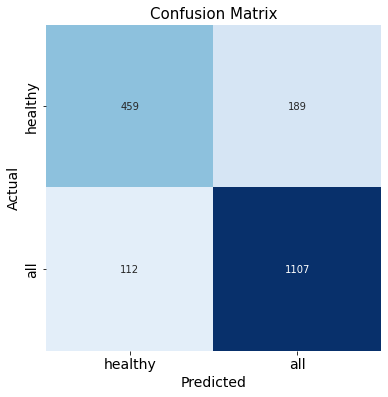

Classification Report:
----------------------
               precision    recall  f1-score   support

     healthy       0.80      0.71      0.75       648
         all       0.85      0.91      0.88      1219

    accuracy                           0.84      1867
   macro avg       0.83      0.81      0.82      1867
weighted avg       0.84      0.84      0.84      1867



In [66]:
cm = confusion_matrix(TLABELS, predictions2, labels=[0, 1])
clr = classification_report(TLABELS, predictions2, labels=[0, 1], target_names=["healthy", "all"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["healthy", "all"], fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=["healthy", "all"], fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=15)
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [75]:
from sklearn.metrics import roc_auc_score
roc_auc_score(TLABELS, predictions2)

0.808227372162975

In [78]:
def model_evaluation(model, test_dataset):
  predictions = np.squeeze(model.predict(test_dataset))
  predictions = (predictions>= 0.5).astype(int)
  cm = confusion_matrix(TLABELS, predictions, labels=[0, 1])
  clr = classification_report(TLABELS, predictions, labels=[0, 1], target_names=["healthy", "all"])
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=["healthy", "all"], fontsize=14)
  plt.yticks(ticks=[0.5, 1.5], labels=["healthy", "all"], fontsize=14)
  plt.xlabel("Predicted", fontsize=14 )
  plt.ylabel("Actual", fontsize=14)
  plt.title("Confusion Matrix", fontsize=15)
  plt.show()
  print("Classification Report:\n----------------------\n", clr)

## Delete model and clear session

In [ ]:
# del model_list_all
# from keras import backend as K 

# K.clear_session()